In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import duckdb
con = duckdb.connect()

In [2]:
import warnings
warnings.filterwarnings('ignore')

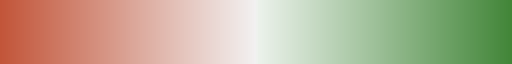

In [3]:
sns.set_theme()
sns.set_style('ticks', {"axes.grid": True})
sns.set_context('talk')
hm_w = 7.5
hm_h = 2.75
set_title = False
my_cmap = sns.diverging_palette(20, 125, as_cmap=True)
my_cmap

In [4]:
my_palette = sns.diverging_palette(20, 125, as_cmap=False)
my_palette

[(0.7634747047461135, 0.3348456555528834, 0.225892295531744),
 (0.8384144678873866, 0.5785740917778832, 0.5129511551488872),
 (0.9140860646530862, 0.8246826885128927, 0.8028133239419791),
 (0.7974936879014439, 0.868249489534432, 0.788438813627399),
 (0.5270994310316574, 0.6954476571009066, 0.5033714796732588),
 (0.25932020565964425, 0.5243170222731213, 0.22106108318482592)]

In [5]:
two_palette = [my_palette[5], my_palette[0]]

In [6]:
systems = ['duckdb', 'umbra']
markers = ['o', '^'] #['d' for _ in range(len(systems))]

In [7]:
def system_case(s):
    if s == 'duckdb':
        return 'DuckDB'
    elif s == 'umbra':
        return 'Umbra'
    else:
        return s

In [8]:
def fix_ylim(ax):
    min_y = 1e99
    for col in ax.collections:
        min_y = min(min_y, col.get_offsets()[0][1])
    diff = ax.get_ylim()[0] - min_y
    ax.set_ylim(bottom=diff)

In [23]:
def parse_cs_csv():
    q = []
    for sys in systems:
        for sf in [10, 100]:
            q.append(f"""
                      select column0 as q, column1 as time, '{system_case(sys)}' as system, {sf} as sf
                      from read_csv_auto('../results/{sys}/tpcds/sf{sf}/catalog_sales/results.csv')
                      """)
    q = " UNION ALL ".join(q)
    con.execute(f"""
    with csv_cte as (
        {q}
    ), fixed as (
        select string_split(q, 'sorting')[1]::INT q, time, system, sf
        from csv_cte
    )
    select q, median(time) as time, system, sf
    from fixed
    group by q, system, sf
    """)
    return con.fetchdf()

In [24]:
def parse_c_csv():
    q = []
    for sys in systems:
        for sf in [10, 100]:
            q.append(f"""
                      select column0 as q, column1 as time, '{system_case(sys)}' as system, {sf} as sf
                      from read_csv_auto('../results/{sys}/tpcds/sf{sf}/customer/results.csv')
                      """)
    q = " UNION ALL ".join(q)
    con.execute(f"""
    with csv_cte as (
        {q}
    )
    select case when q = 'sort_ints' then 'integer' else 'string' end as q,
           median(time) as time, system, sf
    from csv_cte
    group by q, system, sf
    """)
    return con.fetchdf()

# Catalog Sales

In [25]:
cs_df = parse_cs_csv()
cs_df.head()

,q,time,system,sf
0,1,0.352441,DuckDB,10
1,2,0.378332,DuckDB,10
2,3,0.511891,DuckDB,10
3,4,0.543758,DuckDB,10
4,1,4.487421,DuckDB,100


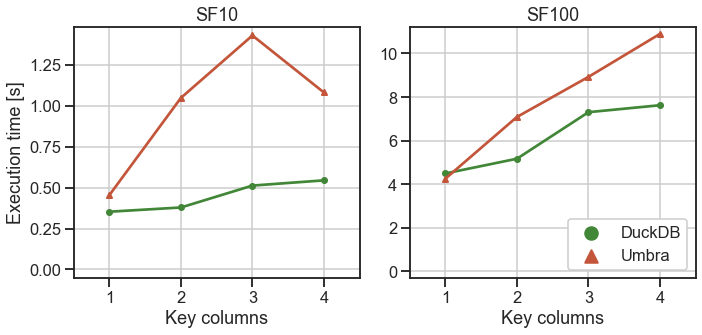

In [30]:
with plt.rc_context({'lines.linewidth': 1.5}):
    plot = sns.catplot(data=cs_df, col='sf', kind='point', markers=markers, x='q', y='time',
                       hue='system', sharey=False, sharex=True, col_wrap=2,
                       palette=two_palette, facet_kws=dict(despine=False))

for i, ax in enumerate(plot.axes):
    ax.set_ylabel('Execution time [s]')
    
    fix_ylim(ax)
    if i == 0:
        ax.set_title('SF10')
    else:
        ax.set_title('SF100')
        ax.set_ylabel('')
    ax.set_xlabel('Key columns')
    ax.grid(True)
    for col in ax.collections:
        col.set_sizes([25])

for lh in plot._legend.legendHandles:
    lh._sizes = [100]
    lh._linewidths = [5]
    
plot._legend.set_visible(False)
handles, labels = plot.axes[0].get_legend_handles_labels()

with plt.rc_context({'legend.markerscale': 2.5}):
    lgnd = plot.axes[1].legend(handles=handles, labels=labels, frameon=True, framealpha=1, loc='lower right')

plt.savefig('figs_sigmod/catalog_sales.eps', bbox_inches="tight")

# Customer

In [27]:
c_df = parse_c_csv()
c_df.head()

,q,time,system,sf
0,integer,0.058959,DuckDB,10
1,string,0.079680,DuckDB,10
2,integer,0.121511,DuckDB,100
3,string,0.683027,DuckDB,100
4,integer,0.036572,Umbra,10


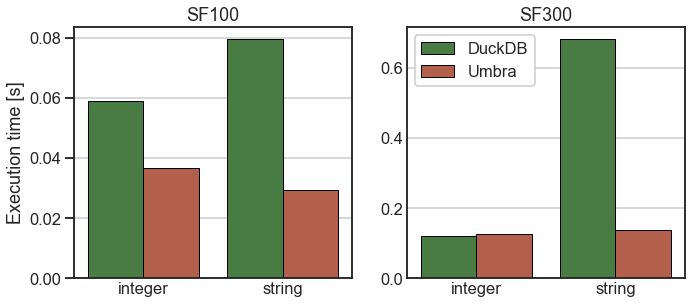

In [28]:
kwargs = {'linewidth': 1, 'edgecolor': 'black'}
plot = sns.catplot(data=c_df, col='sf', kind='bar', x='q', y='time', hue='system',
                   sharey=False, sharex=False, col_wrap=2, palette=two_palette, facet_kws=dict(despine=False),
                   **kwargs)

for i, ax in enumerate(plot.axes):
    if i == 0:
        ax.set_ylabel('Execution time [s]')
        ax.set_title('SF100')
    else:
        ax.set_title('SF300')
        ax.tick_params(axis='y', which='major', length=0)
    ax.tick_params(axis='x', which='major', length=0)
    ax.set_xlabel('')

plot._legend.set_visible(False)
handles, labels = plot.axes[0].get_legend_handles_labels()
lgnd = plot.axes[1].legend(handles=handles, labels=labels, frameon=True, loc='upper left', framealpha=1)

plt.savefig('figs_sigmod/key_type.eps', bbox_inches="tight")